In [1]:
import os
import glob
import numpy as np
from tarfile import StreamError
import obspy as op
from obspy import Stream, Inventory
from obspy.taup import TauPyModel
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from obspy.io.sac.sactrace import SACTrace
from obspy.signal.trigger import classic_sta_lta,plot_trigger,trigger_onset

## Procurando os arquivos do evento (formato=SAC):

In [2]:
#Finding sac files:

sac_files = glob.glob('/home/diogoloc/dados_posdoc/ON02_analysis/Events_data/2022/318/2022.318.21.28.00.00/ON.ON02.2022.318.21.28.00.00.*')

## Lendo os arquivos sac:

In [3]:
#Reading sac files:
on_st = Stream()
for i in sac_files:
    on_st+=op.read(i)

## Plotando os arquivos .sac:

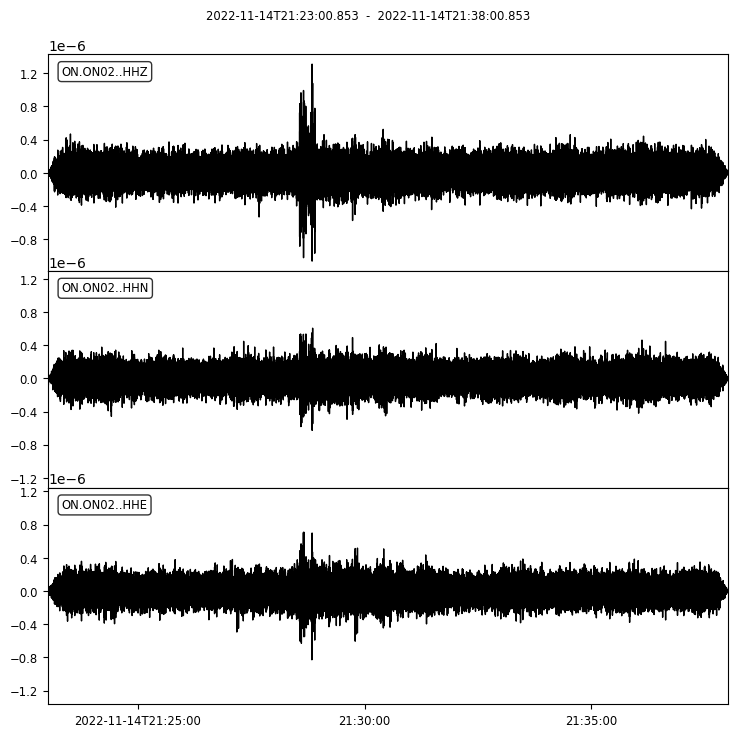

In [4]:
#Plotting sac files:
on_st.detrend('linear')
on_st.detrend('demean')
on_st.filter('highpass', freq=1.0, zerophase=True)
on_st.plot(show=False)

## Plotando os espectrogramas dos arquivos .sac:

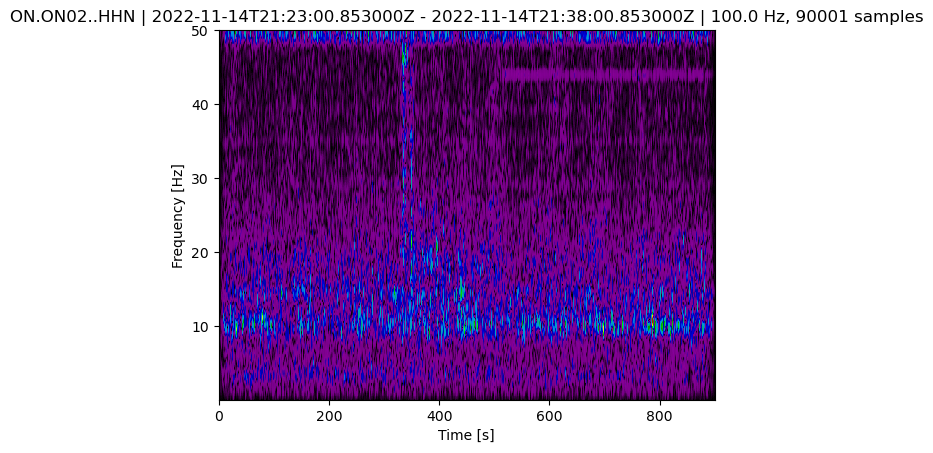

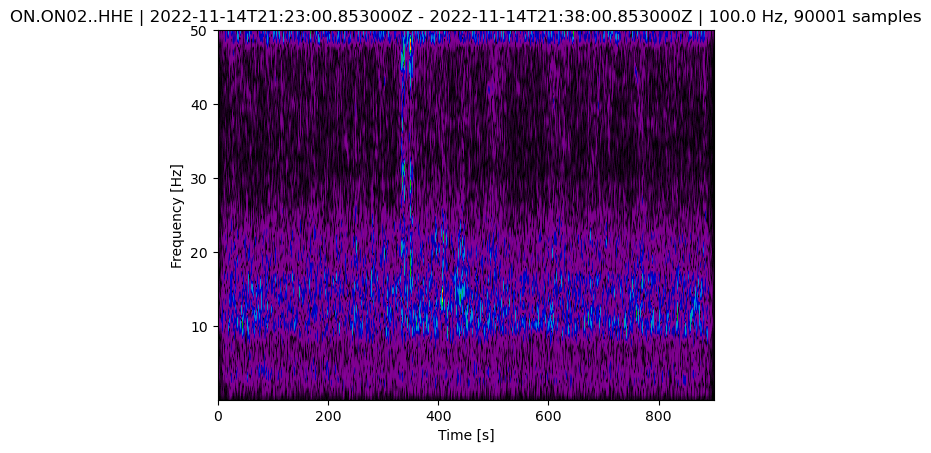

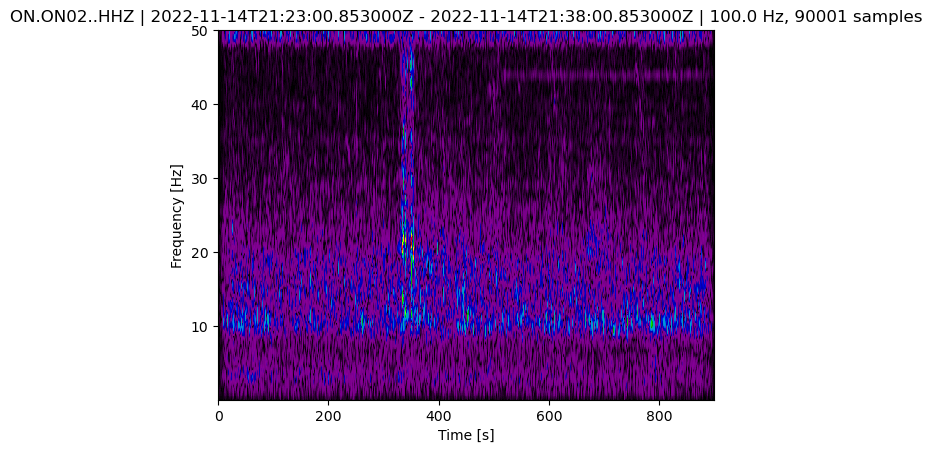

[None, None, None]

In [5]:
on_st.spectrogram(cmap="nipy_spectral")

## Simulando a resposta instrumental de um sensor WOOD-ANDERSON:

#### Filtrado os dados entre 20 e 45 Hz para evitar um ruído constante de 10Hz. 

#### SUMMARY OF MAGNITUDE WORKING GROUP RECOMMENDATIONS ON STANDARD PROCEDURES FOR DETERMINING EARTHQUAKE MAGNITUDES FROM DIGITAL DATA
[2013 March 27]

http://www.iaspei.org/commissions/commission-on-seismological-observation-and-interpretation/Summary_WG_recommendations_20130327.pdf

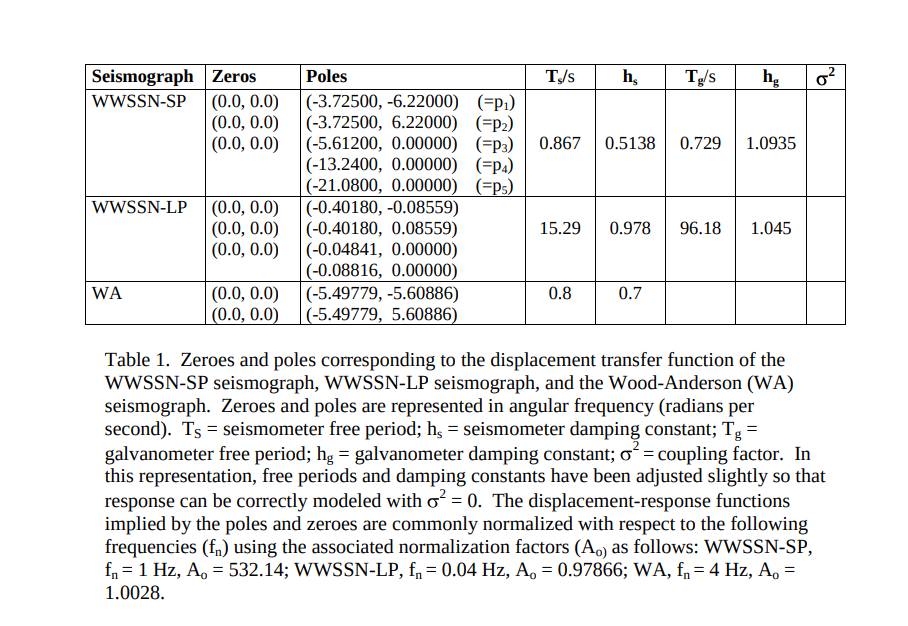

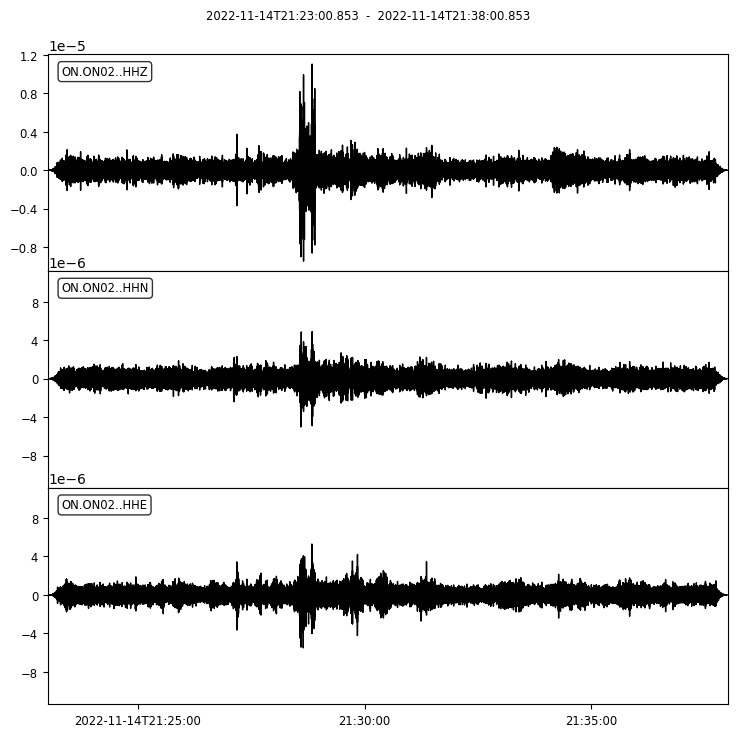

In [6]:
# Reading events files


paz_wa = {'sensitivity': 2080, 'zeros': [0j], 'gain': 1,
          'poles': [-5.49779 -5.60886j, -5.49779 + 5.60886j]}

on_st.simulate(paz_remove=None, paz_simulate=paz_wa, water_level=60)
on_st.filter('bandpass', freqmin=20,freqmax=45, zerophase=True)
on_st.plot(show=False)

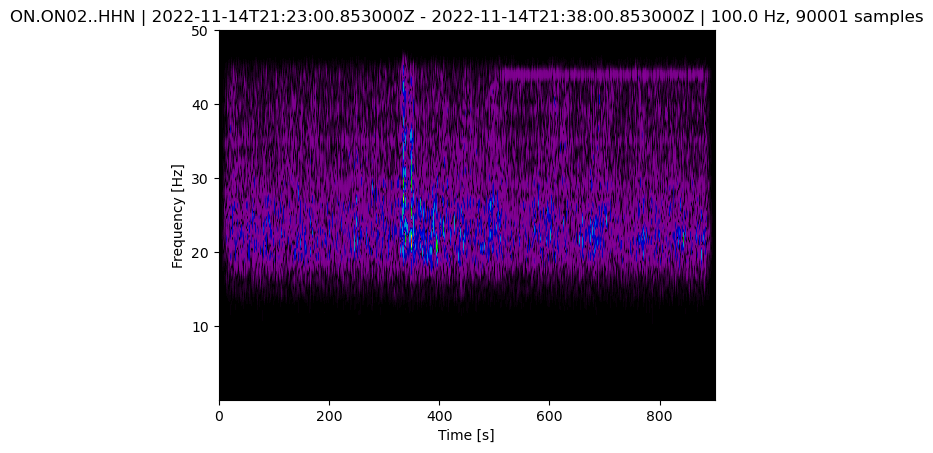

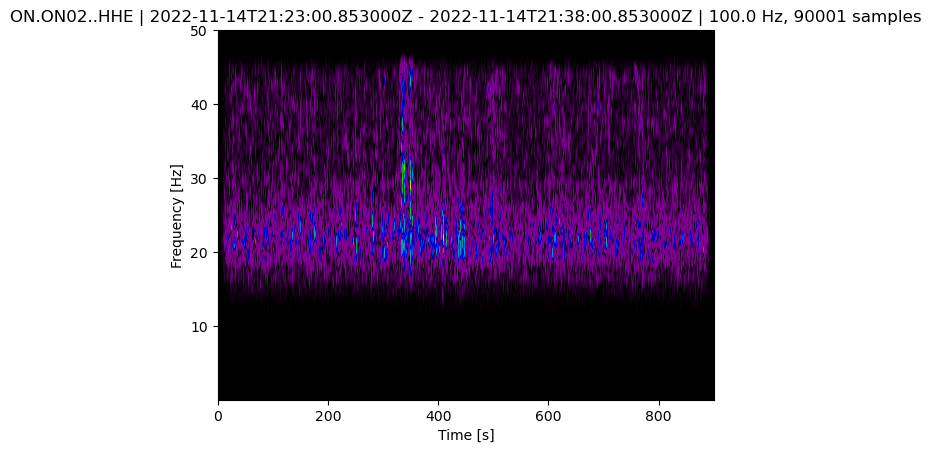

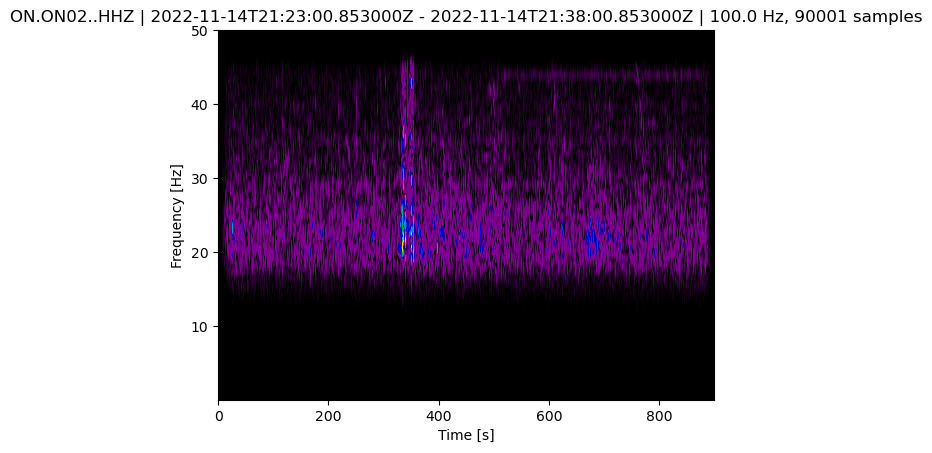

[None, None, None]

In [7]:
on_st.spectrogram(cmap='nipy_spectral')

## Buscando o tempo de chegada da onda P através da metodologia STA/LTA:

In [11]:
df = on_st[0].stats.sampling_rate

nsta = 4
nlta = 100

thres1 = 5
thres2 = 0.5
# Characteristic function and trigger onsets
cft = classic_sta_lta(on_st[-2].data, int(nsta * df), int(nlta * df))
on_of = trigger_onset(cft, thres1, thres2)

In [12]:
on_of

array([[33516, 36015]])

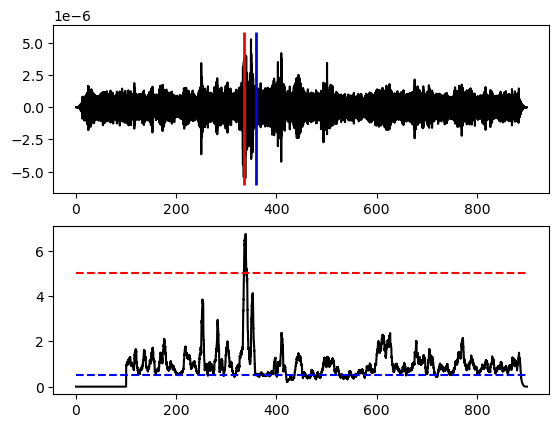

In [13]:
# Plotting the results
for i in on_of:
    ax = plt.subplot(211)
    plt.plot(on_st[-2].times(),on_st[-2].data, 'k')
    ymin, ymax = ax.get_ylim()
    plt.vlines(on_st[-2].times()[i[0]], ymin, ymax, color='r', linewidth=2)
    plt.vlines(on_st[-2].times()[i[1]], ymin, ymax, color='b', linewidth=2)
    
    plt.subplot(212, sharex=ax)
    plt.plot(on_st[-2].times(),cft, 'k')
    plt.hlines([thres1, thres2], on_st[-2].times()[0], on_st[-2].times()[-1], color=['r', 'b'], linestyle='--')
    plt.axis('tight')
    plt.show()

## Cortando a série temporal de acordo com o tempo do evento estimado na metodologia STA/LTA:

In [15]:
event_time = on_st[-2].times("UTCdatetime")[on_of[0][0]]

In [16]:
event_time

2022-11-14T21:28:36.013000Z

In [17]:
on_st.trim(starttime=event_time-10,endtime=event_time+40)

3 Trace(s) in Stream:
ON.ON02..HHN | 2022-11-14T21:28:26.013000Z - 2022-11-14T21:29:16.013000Z | 100.0 Hz, 5001 samples
ON.ON02..HHE | 2022-11-14T21:28:26.013000Z - 2022-11-14T21:29:16.013000Z | 100.0 Hz, 5001 samples
ON.ON02..HHZ | 2022-11-14T21:28:26.013000Z - 2022-11-14T21:29:16.013000Z | 100.0 Hz, 5001 samples

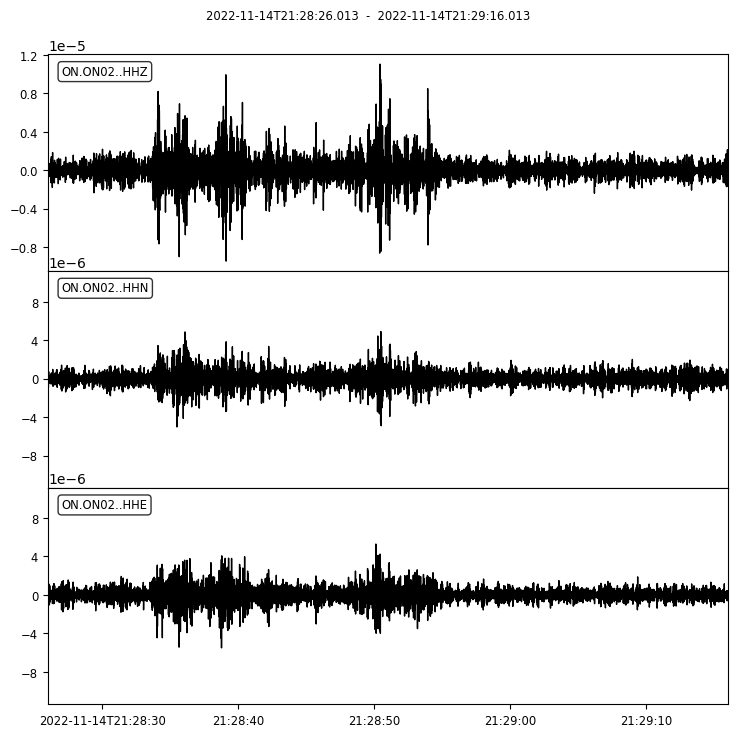

In [18]:
on_st.plot(show=False)

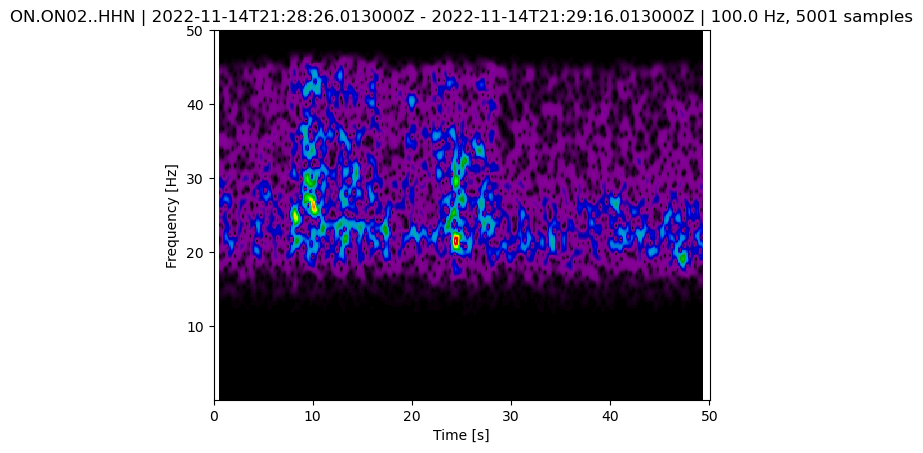

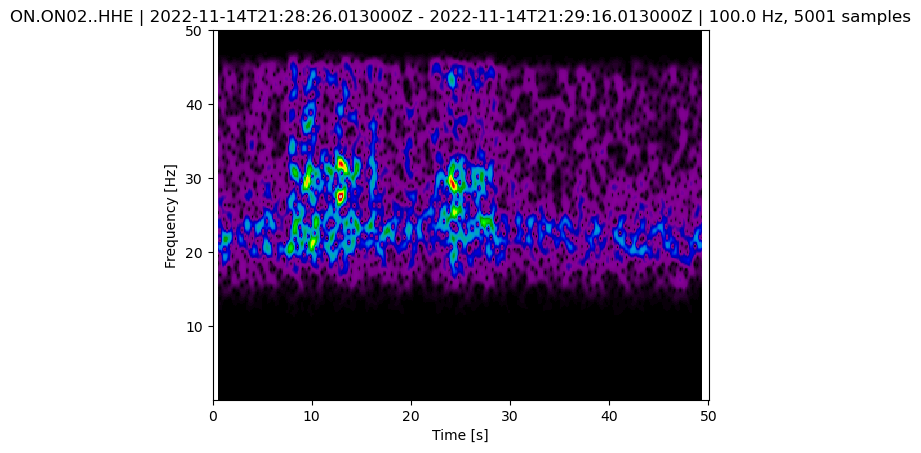

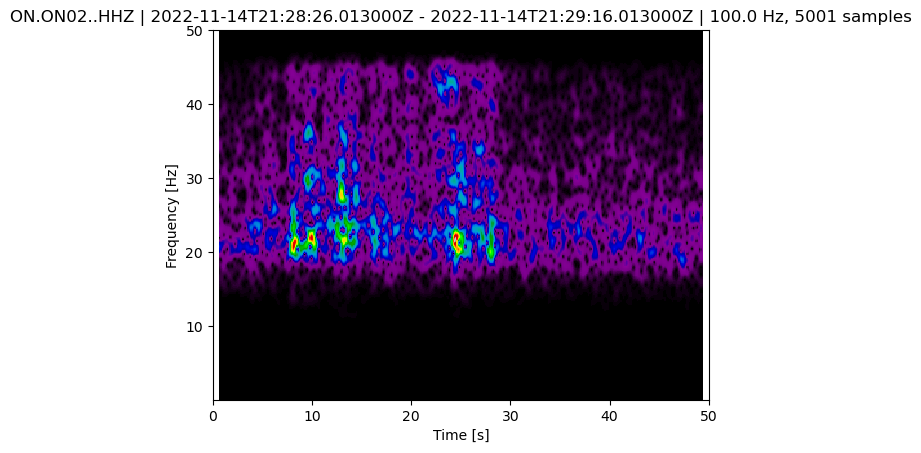

[None, None, None]

In [19]:
on_st.spectrogram(cmap='nipy_spectral')

## Calculando a magnitude de acordo com a amplitude máxima das componentes horizontais:

### Função para calcular a magnitude local:


$M_\text{lh} = \log_{10}\left(amp \cdot 10^9\mathrm{(\frac{nm}{m})}\right) +
a \cdot d_\text{epi (km)} + b$

In [20]:
def mlh_formula(ampl,dist,a= 0.0189,b = -2.17):
    '''
    Fonte: https://docs.obspy.org/tutorial/advanced_exercise/advanced_exercise.html#estimate-local-magnitude
    
    ampl = maximum trace amplitude in nm (1.0e9*m) that is measured on output 
    from a horizontal-component instrument that is filtered 
    so that the response of the seismograph/filter system 
    replicates that of a Wood-Anderson standard seismograph 
    
    dist = hypocentral distance in km, typically less than 1000 km. 
    '''
    
    mlh = np.log10(ampl*1.0e9) + (a * dist) + b

    return mlh


### Calculando a magnitude local:


In [21]:
tr_z = on_st.select(component="Z")[0]

tr_n = on_st.select(component="N")[0]
ampl_n = max(abs(tr_n.data))
id_n = np.argmax(abs(tr_n.data))
mag_ml_n = str(round(mlh_formula(ampl_n,tr_n.stats.sac.dist),2))

tr_e = on_st.select(component="E")[0]
ampl_e = max(abs(tr_e.data))
id_e = np.argmax(abs(tr_e.data))
mag_ml_e = str(round(mlh_formula(ampl_e,tr_e.stats.sac.dist),2))

### Plotando a magnitude local:

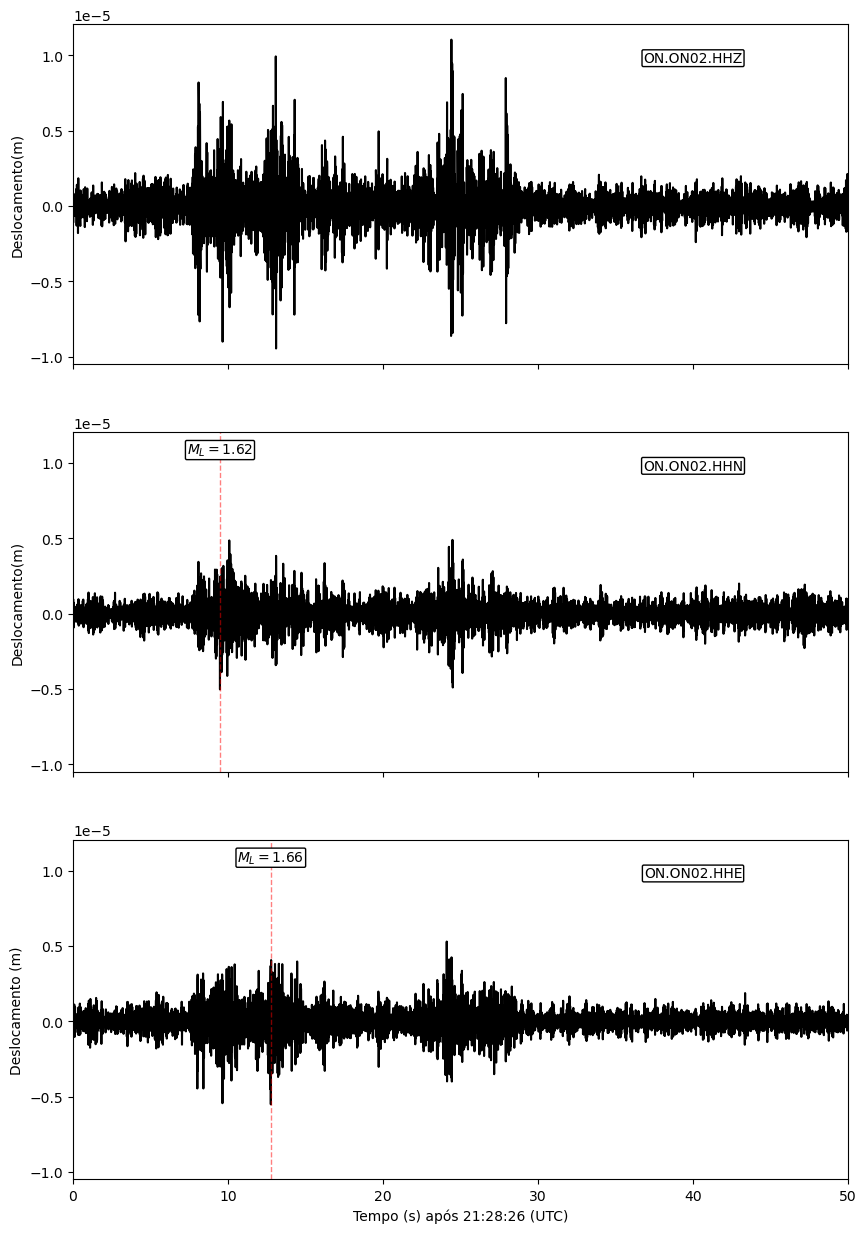

In [22]:
fig, (ax,ax1,ax2) = plt.subplots(3, 1,figsize=(10,15),sharex=True,sharey=True)

ax.plot(tr_z.times(),tr_z.data, 'k')
ymin, ymax = ax.get_ylim()
ax.text(0.8,0.9, tr_z.stats.network+'.'+tr_z.stats.station+'.'+tr_z.stats.channel,transform=ax.transAxes,ha="center", va="center",bbox={'facecolor': 'white', 'pad': 0.1, 'boxstyle':'round'})
ax.set_ylabel("Deslocamento(m)")
ax.set_xlim(tr_z.times()[0],tr_z.times()[-1])
ax.set_ylim(ymin,ymax)

ax1.plot(tr_n.times(),tr_n.data, 'k')
ymin, ymax = ax1.get_ylim()
ax1.vlines(tr_n.times()[id_n], ymin, ymax, ls='--', color='r', linewidth=1,alpha=0.5)
ax1.text(tr_n.times()[id_n],ymax-(ymax*0.1), '$M_{L}=$'+mag_ml_n,ha="center", va="center",bbox={'facecolor': 'white', 'pad': 0.1, 'boxstyle':'round'})
ax1.text(0.8,0.9, tr_n.stats.network+'.'+tr_n.stats.station+'.'+tr_n.stats.channel,transform=ax1.transAxes,ha="center", va="center",bbox={'facecolor': 'white', 'pad': 0.1, 'boxstyle':'round'})
ax1.set_ylabel("Deslocamento(m)")
ax1.set_xlim(tr_n.times()[0],tr_n.times()[-1])
ax1.set_ylim(ymin,ymax)

plt.plot(tr_e.times(),tr_e.data, 'k')
ymin, ymax = ax.get_ylim()
ax2.vlines(tr_e.times()[id_e], ymin, ymax, ls='--', color='r', linewidth=1,alpha=0.5)
ax2.text(tr_e.times()[id_e],ymax-(ymax*0.1), '$M_{L}=$'+mag_ml_e,ha="center", va="center",bbox={'facecolor': 'white', 'pad': 0.1, 'boxstyle':'round'})
ax2.text(0.8,0.9, tr_e.stats.network+'.'+tr_e.stats.station+'.'+tr_e.stats.channel,transform=ax2.transAxes,ha="center", va="center",bbox={'facecolor': 'white', 'pad': 0.1, 'boxstyle':'round'})
ax2.set_ylabel("Deslocamento (m)")
ax2.set_xlabel('Tempo (s) após '+tr_e.stats.starttime.strftime('%H:%M:%S')+' (UTC)')
ax2.set_xlim(tr_e.times()[0],tr_e.times()[-1])
ax2.set_ylim(ymin,ymax)

plt.show()

### Estimando a magnitude final:

In [23]:
ampl = max(ampl_n, ampl_e)

mag_mlh = round(mlh_formula(ampl,tr_e.stats.sac.dist),2)
mag_mlh

1.66